# Initialize Reddit API client
reddit = praw.Reddit(
    client_id='HV1qR_ppGpNhq8cEou2weA',     # Your client ID from Reddit API
    client_secret='S4Q-yOUdaoE00XhU_1f8pj2getKdhQ',  # Your client secret from Reddit API
    user_agent='xrp_sentiment'    # A user agent string, e.g., 'myBot'

In [1]:
pip install praw yfinance ta transformers torch backtrader seaborn ta-lib

Note: you may need to restart the kernel to use updated packages.


# Data Collection

### Reddit Sentiment

In [4]:
import praw
import pandas as pd
import numpy as np
import torch
from datetime import datetime, timedelta
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import json  # Add this import statement

# Initialize Reddit API client (replace with your own credentials)
reddit = praw.Reddit(
    client_id='HV1qR_ppGpNhq8cEou2weA',
    client_secret='S4Q-yOUdaoE00XhU_1f8pj2getKdhQ',
    user_agent='sentiment_analysis_script'
)

# Save the date range to a JSON file
now = datetime.utcnow()
seven_days_ago = now - timedelta(days=7)
date_range = {
    "start_date": seven_days_ago.strftime('%Y-%m-%d'),
    "end_date": now.strftime('%Y-%m-%d')
}
with open('date_range.json', 'w') as f:
    json.dump(date_range, f)

# Define the subreddits and keywords to filter (for XRP-related run)
subreddits_xrp = ['XRP', 'cryptocurrency', 'Ripple']  # Subreddits related to XRP
keywords_xrp = ['XRP', 'Ripple']  # Keywords related to XRP

# Initialize the BERT sentiment analyzer (using FinBERT)
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

# Function to perform sentiment analysis using FinBERT
def bert_sentiment_analysis(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1).detach().numpy()[0]
    sentiment_score = probabilities[0] - probabilities[2]  # Positive probability minus negative probability
    return sentiment_score

# Logarithmic weighted sentiment score function
def weighted_sentiment(sentiment_score, upvotes, downvotes):
    if upvotes > 0 or downvotes > 0:
        vote_ratio = upvotes / max(1, downvotes)
        log_weight = np.log1p(vote_ratio)
        return sentiment_score * log_weight
    return sentiment_score

# Time range for data collection (last 7 days)
now = datetime.utcnow()
seven_days_ago = now - timedelta(days=7)

# Function to check if a post contains any of the keywords
def contains_keywords(text, keywords):
    text = text.lower()
    for keyword in keywords:
        if keyword.lower() in text:
            return True
    return False

# Function to analyze sentiment data from Reddit posts and comments
def analyze_sentiment_data(subreddit_name, keywords):
    posts_with_sentiment = []
    comments_with_sentiment = []
    subreddit = reddit.subreddit(subreddit_name)

    # Fetch all submissions within the last 7 days and collect them into a list
    submissions = [submission for submission in subreddit.new(limit=None) if pd.Timestamp(datetime.utcfromtimestamp(submission.created_utc)) >= seven_days_ago]
    
    # Identify posts containing keywords and extend to 3 posts before and after
    keyword_indices = []
    for idx, submission in enumerate(submissions):
        combined_text = submission.title + ' ' + submission.selftext
        if contains_keywords(combined_text, keywords):
            keyword_indices.append(idx)

    # Create a list of post indices to evaluate: keyword posts and posts up to 3 away
    indices_to_evaluate = set()
    for idx in keyword_indices:
        indices_to_evaluate.update(range(max(0, idx - 3), min(len(submissions), idx + 4)))  # Include posts 3 before and after

    # Now analyze posts based on the collected indices
    for idx in indices_to_evaluate:
        submission = submissions[idx]
        post_time = pd.Timestamp(datetime.utcfromtimestamp(submission.created_utc)).round('T')
        
        combined_text = submission.title + ' ' + submission.selftext
        sentiment_score = bert_sentiment_analysis(combined_text)
        weighted_score = weighted_sentiment(sentiment_score, submission.ups, submission.downs)

        posts_with_sentiment.append({
            'subreddit': subreddit_name,
            'time': post_time,
            'keyword': ', '.join([kw for kw in keywords if kw.lower() in combined_text.lower()]),  # Labels the matching keyword
            'sentiment_score': sentiment_score,
            'weighted_sentiment_score': weighted_score,
            'type': 'post',
            'text': combined_text
        })

        # Fetch and analyze comments for the post
        submission.comments.replace_more(limit=None)
        for comment in submission.comments.list():
            comment_time = pd.Timestamp(datetime.utcfromtimestamp(comment.created_utc)).round('T')
            if comment_time < seven_days_ago:
                continue

            comment_text = comment.body
            sentiment_score = bert_sentiment_analysis(comment_text)
            weighted_score = weighted_sentiment(sentiment_score, comment.ups, comment.downs)

            comments_with_sentiment.append({
                'subreddit': subreddit_name,
                'time': comment_time,
                'keyword': ', '.join([kw for kw in keywords if kw.lower() in combined_text.lower()]),  # Labels the matching keyword
                'sentiment_score': sentiment_score,
                'weighted_sentiment_score': weighted_score,
                'type': 'comment',
                'text': comment_text
            })

    # Convert lists to DataFrames
    posts_df = pd.DataFrame(posts_with_sentiment)
    comments_df = pd.DataFrame(comments_with_sentiment)

    return posts_df, comments_df

# Collect data from multiple subreddits related to XRP
all_posts_xrp = []
all_comments_xrp = []
for subreddit in subreddits_xrp:
    posts_df_xrp, comments_df_xrp = analyze_sentiment_data(subreddit, keywords_xrp)
    if not posts_df_xrp.empty:
        all_posts_xrp.append(posts_df_xrp)
    if not comments_df_xrp.empty:
        all_comments_xrp.append(comments_df_xrp)

# Concatenate posts and comments
if all_posts_xrp and all_comments_xrp:
    xrp_sentiment_df = pd.concat([pd.concat(all_posts_xrp, ignore_index=True), pd.concat(all_comments_xrp, ignore_index=True)], ignore_index=True)

    # Align the time by rounding to the nearest minute
    xrp_sentiment_df['time'] = pd.to_datetime(xrp_sentiment_df['time']).dt.round('T')

    # Group the sentiment data by hour
    xrp_sentiment_df = xrp_sentiment_df.set_index('time').resample('H').agg({
        'weighted_sentiment_score': ['mean', 'std'],  # Compute hourly average and standard deviation (volatility)
    }).reset_index()

    # Flatten the multi-level columns
    xrp_sentiment_df.columns = ['time', 'hourly_sentiment_avg', 'hourly_sentiment_volatility']

    # Calculate hourly sentiment momentum (difference between consecutive hours)
    xrp_sentiment_df['hourly_sentiment_momentum'] = xrp_sentiment_df['hourly_sentiment_avg'].diff()

    # Save the hourly sentiment data to CSV
    xrp_sentiment_df.to_csv('xrp_hourly_sentiment_data.csv', index=False)

    print("Hourly Sentiment Averages, Volatility, and Momentum for XRP:")
    print(xrp_sentiment_df.head())

else:
    print("No relevant posts or comments found for XRP in the last 7 days.")

KeyboardInterrupt: 

### XRP/USD OHLCV Data

In [ ]:
import requests
import pandas as pd
import time
import json

# Load the date range from the JSON file
with open('date_range.json', 'r') as f:
    date_range = json.load(f)

start_date = date_range['start_date']
end_date = date_range['end_date']

# Function to fetch minute-level OHLCV data from Binance
def fetch_binance_minute_data(symbol='XRPUSDT', interval='1m', start_time=None, end_time=None):
    url = "https://api.binance.com/api/v3/klines"
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_time,
        'endTime': end_time,
        'limit': 1000
    }

    response = requests.get(url, params=params)
    data = response.json()

    if "code" in data:
        raise ValueError(f"Error fetching data: {data['msg']}")

    columns = ['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 
               'Close Time', 'Quote Asset Volume', 'Number of Trades', 
               'Taker Buy Base Asset Volume', 'Taker Buy Quote Asset Volume', 'Ignore']
    df = pd.DataFrame(data, columns=columns)
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')

    return df

# Function to fetch data over multiple days
def fetch_binance_data_for_period(symbol, start_date, end_date):
    all_data = pd.DataFrame()
    interval_ms = 60000  # 1 minute in milliseconds
    limit_ms = interval_ms * 1000  # Binance limit is 1000 minutes
    start_time = int(time.mktime(time.strptime(start_date, '%Y-%m-%d')) * 1000)
    end_time = int(time.mktime(time.strptime(end_date, '%Y-%m-%d')) * 1000)

    while start_time < end_time:
        batch_end_time = min(start_time + limit_ms, end_time)

        print(f"Fetching data from {pd.to_datetime(start_time, unit='ms')} to {pd.to_datetime(batch_end_time, unit='ms')}")

        data = fetch_binance_minute_data(symbol=symbol, start_time=start_time, end_time=batch_end_time)
        all_data = pd.concat([all_data, data], ignore_index=True)

        start_time = int(data['Open Time'].max().timestamp() * 1000)
        time.sleep(1)  # Avoid hitting rate limits

    return all_data

# Fetch OHLCV data using the same date range as sentiment scraper
xrp_ohlcv_df = fetch_binance_data_for_period('XRPUSDT', start_date, end_date)

# Rename and process columns
xrp_ohlcv_df = xrp_ohlcv_df.rename(columns={'Open Time': 'time'})
xrp_ohlcv_df['time'] = pd.to_datetime(xrp_ohlcv_df['time'])

# Print results
print(xrp_ohlcv_df.head())
print(f"Data timestamp range: {xrp_ohlcv_df['time'].min()} to {xrp_ohlcv_df['time'].max()}")

# Save to CSV
xrp_ohlcv_df.to_csv('xrp_ohlcv_data_7days.csv', index=False)

In [ ]:
xrp_minute_data.columns

### XRP Bid/Ask Spread Data

In [3]:
import requests
import pandas as pd
import time
import asyncio
import aiohttp
import json
import nest_asyncio

# Allow nested event loops
nest_asyncio.apply()

# Load the date range from the JSON file
with open('date_range.json', 'r') as f:
    date_range = json.load(f)

# Convert the start and end dates to Unix timestamps (in seconds)
start_time = int(time.mktime(time.strptime(date_range['start_date'], '%Y-%m-%d')))
end_time = int(time.mktime(time.strptime(date_range['end_date'], '%Y-%m-%d')))

# Function to fetch order book data from Binance asynchronously
async def fetch_order_book(session, symbol='XRPUSDT', limit=100):
    url = "https://api.binance.com/api/v3/depth"
    params = {
        'symbol': symbol,
        'limit': limit
    }

    async with session.get(url, params=params) as response:
        data = await response.json()

        if 'code' in data:
            raise ValueError(f"Error from Binance API: {data['msg']}")

        # Create DataFrames for bids and asks
        bids = pd.DataFrame(data['bids'], columns=['Bid Price', 'Bid Quantity'])
        asks = pd.DataFrame(data['asks'], columns=['Ask Price', 'Ask Quantity'])

        return bids, asks

# Function to continuously fetch order book data asynchronously
async def capture_order_book_over_time(start_time, end_time, symbol='XRPUSDT', interval=60, limit=100):
    all_bids = []
    all_asks = []

    async with aiohttp.ClientSession() as session:
        current_time = start_time
        while current_time < end_time:
            print(f"Fetching data at: {pd.to_datetime(current_time, unit='s')}")

            # Fetch order book data asynchronously
            bids, asks = await fetch_order_book(session, symbol=symbol, limit=limit)

            # Add timestamp to the bids and asks
            timestamp = pd.to_datetime(current_time, unit='s')
            bids['Timestamp'] = timestamp
            asks['Timestamp'] = timestamp

            all_bids.append(bids)
            all_asks.append(asks)

            # Increment current time by the interval
            current_time += interval

            await asyncio.sleep(1)  # Adjust sleep to avoid rate limits

    # Concatenate all collected bids and asks
    xrp_bids_df = pd.concat(all_bids, ignore_index=True)
    xrp_asks_df = pd.concat(all_asks, ignore_index=True)

    # Create bid/ask spread DataFrame
    xrp_spread_df = pd.merge_asof(
        xrp_bids_df[['Timestamp', 'Bid Price']],
        xrp_asks_df[['Timestamp', 'Ask Price']],
        on='Timestamp',
        direction='nearest'
    )

    # Calculate the bid/ask spread
    xrp_spread_df['Bid/Ask Spread'] = xrp_spread_df['Ask Price'] - xrp_spread_df['Bid Price']

    return xrp_bids_df, xrp_asks_df, xrp_spread_df

# Run the async function using the loaded date range
xrp_bids_df, xrp_asks_df, xrp_spread_df = await capture_order_book_over_time(
    start_time=start_time, end_time=end_time
)

# Print the first few results
print(xrp_bids_df.head())
print(xrp_asks_df.head())
print(xrp_spread_df.head())

# Save the data to CSV
xrp_bids_df.to_csv('binance_xrp_bids.csv', index=False)
xrp_asks_df.to_csv('binance_xrp_asks.csv', index=False)
xrp_spread_df.to_csv('binance_xrp_spread.csv', index=False)

Fetching data at: 2024-10-09 07:00:00
Fetching data at: 2024-10-09 07:01:00
Fetching data at: 2024-10-09 07:02:00
Fetching data at: 2024-10-09 07:03:00
Fetching data at: 2024-10-09 07:04:00
Fetching data at: 2024-10-09 07:05:00
Fetching data at: 2024-10-09 07:06:00
Fetching data at: 2024-10-09 07:07:00
Fetching data at: 2024-10-09 07:08:00
Fetching data at: 2024-10-09 07:09:00
Fetching data at: 2024-10-09 07:10:00
Fetching data at: 2024-10-09 07:11:00
Fetching data at: 2024-10-09 07:12:00
Fetching data at: 2024-10-09 07:13:00
Fetching data at: 2024-10-09 07:14:00
Fetching data at: 2024-10-09 07:15:00
Fetching data at: 2024-10-09 07:16:00
Fetching data at: 2024-10-09 07:17:00
Fetching data at: 2024-10-09 07:18:00
Fetching data at: 2024-10-09 07:19:00
Fetching data at: 2024-10-09 07:20:00
Fetching data at: 2024-10-09 07:21:00
Fetching data at: 2024-10-09 07:22:00
Fetching data at: 2024-10-09 07:23:00
Fetching data at: 2024-10-09 07:24:00
Fetching data at: 2024-10-09 07:25:00
Fetching dat

Fetching data at: 2024-10-09 10:36:00
Fetching data at: 2024-10-09 10:37:00
Fetching data at: 2024-10-09 10:38:00
Fetching data at: 2024-10-09 10:39:00
Fetching data at: 2024-10-09 10:40:00
Fetching data at: 2024-10-09 10:41:00
Fetching data at: 2024-10-09 10:42:00
Fetching data at: 2024-10-09 10:43:00
Fetching data at: 2024-10-09 10:44:00
Fetching data at: 2024-10-09 10:45:00
Fetching data at: 2024-10-09 10:46:00
Fetching data at: 2024-10-09 10:47:00
Fetching data at: 2024-10-09 10:48:00
Fetching data at: 2024-10-09 10:49:00
Fetching data at: 2024-10-09 10:50:00
Fetching data at: 2024-10-09 10:51:00
Fetching data at: 2024-10-09 10:52:00
Fetching data at: 2024-10-09 10:53:00
Fetching data at: 2024-10-09 10:54:00
Fetching data at: 2024-10-09 10:55:00
Fetching data at: 2024-10-09 10:56:00
Fetching data at: 2024-10-09 10:57:00
Fetching data at: 2024-10-09 10:58:00
Fetching data at: 2024-10-09 10:59:00
Fetching data at: 2024-10-09 11:00:00
Fetching data at: 2024-10-09 11:01:00
Fetching dat

Fetching data at: 2024-10-09 14:12:00
Fetching data at: 2024-10-09 14:13:00
Fetching data at: 2024-10-09 14:14:00
Fetching data at: 2024-10-09 14:15:00
Fetching data at: 2024-10-09 14:16:00
Fetching data at: 2024-10-09 14:17:00
Fetching data at: 2024-10-09 14:18:00
Fetching data at: 2024-10-09 14:19:00
Fetching data at: 2024-10-09 14:20:00
Fetching data at: 2024-10-09 14:21:00
Fetching data at: 2024-10-09 14:22:00
Fetching data at: 2024-10-09 14:23:00
Fetching data at: 2024-10-09 14:24:00
Fetching data at: 2024-10-09 14:25:00
Fetching data at: 2024-10-09 14:26:00
Fetching data at: 2024-10-09 14:27:00
Fetching data at: 2024-10-09 14:28:00
Fetching data at: 2024-10-09 14:29:00
Fetching data at: 2024-10-09 14:30:00
Fetching data at: 2024-10-09 14:31:00
Fetching data at: 2024-10-09 14:32:00
Fetching data at: 2024-10-09 14:33:00
Fetching data at: 2024-10-09 14:34:00
Fetching data at: 2024-10-09 14:35:00
Fetching data at: 2024-10-09 14:36:00
Fetching data at: 2024-10-09 14:37:00
Fetching dat

Fetching data at: 2024-10-09 17:48:00
Fetching data at: 2024-10-09 17:49:00
Fetching data at: 2024-10-09 17:50:00
Fetching data at: 2024-10-09 17:51:00
Fetching data at: 2024-10-09 17:52:00
Fetching data at: 2024-10-09 17:53:00
Fetching data at: 2024-10-09 17:54:00
Fetching data at: 2024-10-09 17:55:00
Fetching data at: 2024-10-09 17:56:00
Fetching data at: 2024-10-09 17:57:00
Fetching data at: 2024-10-09 17:58:00
Fetching data at: 2024-10-09 17:59:00
Fetching data at: 2024-10-09 18:00:00
Fetching data at: 2024-10-09 18:01:00
Fetching data at: 2024-10-09 18:02:00
Fetching data at: 2024-10-09 18:03:00
Fetching data at: 2024-10-09 18:04:00
Fetching data at: 2024-10-09 18:05:00
Fetching data at: 2024-10-09 18:06:00
Fetching data at: 2024-10-09 18:07:00
Fetching data at: 2024-10-09 18:08:00
Fetching data at: 2024-10-09 18:09:00
Fetching data at: 2024-10-09 18:10:00
Fetching data at: 2024-10-09 18:11:00
Fetching data at: 2024-10-09 18:12:00
Fetching data at: 2024-10-09 18:13:00
Fetching dat

Fetching data at: 2024-10-09 21:24:00
Fetching data at: 2024-10-09 21:25:00
Fetching data at: 2024-10-09 21:26:00
Fetching data at: 2024-10-09 21:27:00
Fetching data at: 2024-10-09 21:28:00
Fetching data at: 2024-10-09 21:29:00
Fetching data at: 2024-10-09 21:30:00
Fetching data at: 2024-10-09 21:31:00
Fetching data at: 2024-10-09 21:32:00
Fetching data at: 2024-10-09 21:33:00
Fetching data at: 2024-10-09 21:34:00
Fetching data at: 2024-10-09 21:35:00
Fetching data at: 2024-10-09 21:36:00
Fetching data at: 2024-10-09 21:37:00
Fetching data at: 2024-10-09 21:38:00
Fetching data at: 2024-10-09 21:39:00
Fetching data at: 2024-10-09 21:40:00
Fetching data at: 2024-10-09 21:41:00
Fetching data at: 2024-10-09 21:42:00
Fetching data at: 2024-10-09 21:43:00
Fetching data at: 2024-10-09 21:44:00
Fetching data at: 2024-10-09 21:45:00
Fetching data at: 2024-10-09 21:46:00
Fetching data at: 2024-10-09 21:47:00
Fetching data at: 2024-10-09 21:48:00
Fetching data at: 2024-10-09 21:49:00
Fetching dat

Fetching data at: 2024-10-10 01:00:00
Fetching data at: 2024-10-10 01:01:00
Fetching data at: 2024-10-10 01:02:00
Fetching data at: 2024-10-10 01:03:00
Fetching data at: 2024-10-10 01:04:00
Fetching data at: 2024-10-10 01:05:00
Fetching data at: 2024-10-10 01:06:00
Fetching data at: 2024-10-10 01:07:00
Fetching data at: 2024-10-10 01:08:00
Fetching data at: 2024-10-10 01:09:00
Fetching data at: 2024-10-10 01:10:00
Fetching data at: 2024-10-10 01:11:00
Fetching data at: 2024-10-10 01:12:00
Fetching data at: 2024-10-10 01:13:00
Fetching data at: 2024-10-10 01:14:00
Fetching data at: 2024-10-10 01:15:00
Fetching data at: 2024-10-10 01:16:00
Fetching data at: 2024-10-10 01:17:00
Fetching data at: 2024-10-10 01:18:00
Fetching data at: 2024-10-10 01:19:00
Fetching data at: 2024-10-10 01:20:00
Fetching data at: 2024-10-10 01:21:00
Fetching data at: 2024-10-10 01:22:00
Fetching data at: 2024-10-10 01:23:00
Fetching data at: 2024-10-10 01:24:00
Fetching data at: 2024-10-10 01:25:00
Fetching dat

Fetching data at: 2024-10-10 04:36:00
Fetching data at: 2024-10-10 04:37:00
Fetching data at: 2024-10-10 04:38:00
Fetching data at: 2024-10-10 04:39:00
Fetching data at: 2024-10-10 04:40:00
Fetching data at: 2024-10-10 04:41:00
Fetching data at: 2024-10-10 04:42:00
Fetching data at: 2024-10-10 04:43:00
Fetching data at: 2024-10-10 04:44:00
Fetching data at: 2024-10-10 04:45:00
Fetching data at: 2024-10-10 04:46:00
Fetching data at: 2024-10-10 04:47:00
Fetching data at: 2024-10-10 04:48:00
Fetching data at: 2024-10-10 04:49:00
Fetching data at: 2024-10-10 04:50:00
Fetching data at: 2024-10-10 04:51:00
Fetching data at: 2024-10-10 04:52:00
Fetching data at: 2024-10-10 04:53:00
Fetching data at: 2024-10-10 04:54:00
Fetching data at: 2024-10-10 04:55:00
Fetching data at: 2024-10-10 04:56:00
Fetching data at: 2024-10-10 04:57:00
Fetching data at: 2024-10-10 04:58:00
Fetching data at: 2024-10-10 04:59:00
Fetching data at: 2024-10-10 05:00:00
Fetching data at: 2024-10-10 05:01:00
Fetching dat

Fetching data at: 2024-10-10 08:12:00
Fetching data at: 2024-10-10 08:13:00
Fetching data at: 2024-10-10 08:14:00
Fetching data at: 2024-10-10 08:15:00
Fetching data at: 2024-10-10 08:16:00
Fetching data at: 2024-10-10 08:17:00
Fetching data at: 2024-10-10 08:18:00
Fetching data at: 2024-10-10 08:19:00
Fetching data at: 2024-10-10 08:20:00
Fetching data at: 2024-10-10 08:21:00
Fetching data at: 2024-10-10 08:22:00
Fetching data at: 2024-10-10 08:23:00
Fetching data at: 2024-10-10 08:24:00
Fetching data at: 2024-10-10 08:25:00
Fetching data at: 2024-10-10 08:26:00
Fetching data at: 2024-10-10 08:27:00
Fetching data at: 2024-10-10 08:28:00
Fetching data at: 2024-10-10 08:29:00
Fetching data at: 2024-10-10 08:30:00
Fetching data at: 2024-10-10 08:31:00
Fetching data at: 2024-10-10 08:32:00
Fetching data at: 2024-10-10 08:33:00
Fetching data at: 2024-10-10 08:34:00
Fetching data at: 2024-10-10 08:35:00
Fetching data at: 2024-10-10 08:36:00
Fetching data at: 2024-10-10 08:37:00
Fetching dat

Fetching data at: 2024-10-10 11:48:00
Fetching data at: 2024-10-10 11:49:00
Fetching data at: 2024-10-10 11:50:00
Fetching data at: 2024-10-10 11:51:00
Fetching data at: 2024-10-10 11:52:00
Fetching data at: 2024-10-10 11:53:00
Fetching data at: 2024-10-10 11:54:00
Fetching data at: 2024-10-10 11:55:00
Fetching data at: 2024-10-10 11:56:00
Fetching data at: 2024-10-10 11:57:00
Fetching data at: 2024-10-10 11:58:00
Fetching data at: 2024-10-10 11:59:00
Fetching data at: 2024-10-10 12:00:00
Fetching data at: 2024-10-10 12:01:00
Fetching data at: 2024-10-10 12:02:00
Fetching data at: 2024-10-10 12:03:00
Fetching data at: 2024-10-10 12:04:00
Fetching data at: 2024-10-10 12:05:00
Fetching data at: 2024-10-10 12:06:00
Fetching data at: 2024-10-10 12:07:00
Fetching data at: 2024-10-10 12:08:00
Fetching data at: 2024-10-10 12:09:00
Fetching data at: 2024-10-10 12:10:00
Fetching data at: 2024-10-10 12:11:00
Fetching data at: 2024-10-10 12:12:00
Fetching data at: 2024-10-10 12:13:00
Fetching dat

Fetching data at: 2024-10-10 15:24:00
Fetching data at: 2024-10-10 15:25:00
Fetching data at: 2024-10-10 15:26:00
Fetching data at: 2024-10-10 15:27:00
Fetching data at: 2024-10-10 15:28:00
Fetching data at: 2024-10-10 15:29:00
Fetching data at: 2024-10-10 15:30:00
Fetching data at: 2024-10-10 15:31:00
Fetching data at: 2024-10-10 15:32:00
Fetching data at: 2024-10-10 15:33:00
Fetching data at: 2024-10-10 15:34:00
Fetching data at: 2024-10-10 15:35:00
Fetching data at: 2024-10-10 15:36:00
Fetching data at: 2024-10-10 15:37:00
Fetching data at: 2024-10-10 15:38:00
Fetching data at: 2024-10-10 15:39:00
Fetching data at: 2024-10-10 15:40:00
Fetching data at: 2024-10-10 15:41:00
Fetching data at: 2024-10-10 15:42:00
Fetching data at: 2024-10-10 15:43:00
Fetching data at: 2024-10-10 15:44:00
Fetching data at: 2024-10-10 15:45:00
Fetching data at: 2024-10-10 15:46:00
Fetching data at: 2024-10-10 15:47:00
Fetching data at: 2024-10-10 15:48:00
Fetching data at: 2024-10-10 15:49:00
Fetching dat

Fetching data at: 2024-10-10 19:00:00
Fetching data at: 2024-10-10 19:01:00
Fetching data at: 2024-10-10 19:02:00
Fetching data at: 2024-10-10 19:03:00
Fetching data at: 2024-10-10 19:04:00
Fetching data at: 2024-10-10 19:05:00
Fetching data at: 2024-10-10 19:06:00
Fetching data at: 2024-10-10 19:07:00
Fetching data at: 2024-10-10 19:08:00
Fetching data at: 2024-10-10 19:09:00
Fetching data at: 2024-10-10 19:10:00
Fetching data at: 2024-10-10 19:11:00
Fetching data at: 2024-10-10 19:12:00
Fetching data at: 2024-10-10 19:13:00
Fetching data at: 2024-10-10 19:14:00
Fetching data at: 2024-10-10 19:15:00
Fetching data at: 2024-10-10 19:16:00
Fetching data at: 2024-10-10 19:17:00
Fetching data at: 2024-10-10 19:18:00
Fetching data at: 2024-10-10 19:19:00
Fetching data at: 2024-10-10 19:20:00
Fetching data at: 2024-10-10 19:21:00
Fetching data at: 2024-10-10 19:22:00
Fetching data at: 2024-10-10 19:23:00
Fetching data at: 2024-10-10 19:24:00
Fetching data at: 2024-10-10 19:25:00
Fetching dat

ClientConnectorError: Cannot connect to host api.binance.com:443 ssl:default [nodename nor servname provided, or not known]

### XRP Support/Resistance Levels

In [5]:
def calculate_support_resistance(xrp_ohlcv_df, window=30):
    # Calculate rolling Support and Resistance
    support = xrp_ohlcv_df['Low'].rolling(window=window).min()
    resistance = xrp_ohlcv_df['High'].rolling(window=window).max()

    # Create a new DataFrame with Timestamp, Support, and Resistance
    xrp_support_resistance_df = pd.DataFrame({
        'Timestamp': xrp_ohlcv_df['time'],  # Use 'time' column as the timestamp
        'Support': support,
        'Resistance': resistance
    })

    return xrp_support_resistance_df

# Example usage: Calculate support/resistance levels
xrp_support_resistance_df = calculate_support_resistance(xrp_ohlcv_df)

# Print the result
print(xrp_support_resistance_df.tail())

NameError: name 'xrp_ohlcv_df' is not defined

### XRP Technical Indicators

In [ ]:
import talib

# RSI (Relative Strength Index)
def calculate_rsi(xrp_ohlcv_df, period=14):
    rsi = talib.RSI(xrp_ohlcv_df['Price'], timeperiod=period)
    return rsi

# MACD (Moving Average Convergence Divergence)
def calculate_macd(xrp_ohlcv_df, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macd_signal, _ = talib.MACD(
        xrp_ohlcv_df['Price'], 
        fastperiod=fastperiod, 
        slowperiod=slowperiod, 
        signalperiod=signalperiod
    )
    return macd, macd_signal

# Create a separate DataFrame for technical indicators
def create_technical_indicators_df(xrp_ohlcv_df):
    # Calculate indicators
    rsi = calculate_rsi(xrp_ohlcv_df)
    macd, macd_signal = calculate_macd(xrp_ohlcv_df)

    # Create the technical indicators DataFrame
    xrp_technical_indicators_df = pd.DataFrame({
        'Timestamp': xrp_ohlcv_df['time'],  # Use 'time' column as the timestamp
        'RSI': rsi,
        'MACD': macd,
        'MACD_signal': macd_signal
    })

    return xrp_technical_indicators_df

# Example usage
xrp_technical_indicators_df = create_technical_indicators_df(xrp_ohlcv_df)

# Print the result
print(xrp_technical_indicators_df.tail())

# Plotting Comparisons

In [6]:
# Load the cleaned DataFrame from the CSV file
xrp_ohlcv_df = pd.read_csv('xrp_ohlcv_data_7days.csv')

In [7]:
xrp_ohlcv_df.columns

Index(['time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time',
       'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'Ignore'],
      dtype='object')

In [8]:
import plotly.io as pio
pio.renderers.default = 'notebook'  # or 'jupyterlab'

In [16]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Ensure 'time' is in datetime format
xrp_ohlcv_df['time'] = pd.to_datetime(xrp_ohlcv_df['time'])

# Calculate Rolling Mean and Distance from Mean
xrp_ohlcv_df['Rolling Mean'] = xrp_ohlcv_df['Close'].rolling(window=60).mean()
xrp_ohlcv_df['Distance From Mean'] = xrp_ohlcv_df['Close'] - xrp_ohlcv_df['Rolling Mean']

# Calculate Momentum of the Distance from Mean
xrp_ohlcv_df['Momentum'] = xrp_ohlcv_df['Distance From Mean'].diff(5)

# Create subplots with four rows (aligned x-axis)
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=(
        "Price with Rolling Mean", 
        "Distance from Mean", 
        "Momentum of Distance from Mean", 
        "Volume"
    )
)

# Add Price and Rolling Mean to the first subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Close'],
               mode='lines', name='Close Price', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Rolling Mean'],
               mode='lines', name='Rolling Mean', line=dict(color='orange', dash='dash')),
    row=1, col=1
)

# Add Distance from Mean to the second subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Distance From Mean'],
               mode='lines', name='Distance from Mean', line=dict(color='red')),
    row=2, col=1
)

# Add Momentum of Distance from Mean to the third subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Momentum'],
               mode='lines', name='Momentum', line=dict(color='purple')),
    row=3, col=1
)

# Add Volume to the fourth subplot
fig.add_trace(
    go.Bar(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Volume'],
           name='Volume', marker=dict(color='darkgreen')),
    row=4, col=1
)

# Update layout with titles and axis labels
fig.update_layout(
    height=1000, title='XRP Price, Momentum, and Volume Analysis',
    xaxis_title='Time',
    yaxis_title='Price / Rolling Mean',  # Primary y-axis title
)

# Show the plot
fig.show()

In [15]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Ensure 'time' is in datetime format
xrp_ohlcv_df['time'] = pd.to_datetime(xrp_ohlcv_df['time'])

# Calculate Rolling Mean and Distance from Mean
xrp_ohlcv_df['Rolling Mean'] = xrp_ohlcv_df['Close'].rolling(window=60).mean()
xrp_ohlcv_df['Distance From Mean'] = xrp_ohlcv_df['Close'] - xrp_ohlcv_df['Rolling Mean']

# Calculate Momentum of Distance from Mean
xrp_ohlcv_df['Momentum'] = xrp_ohlcv_df['Distance From Mean'].diff(5)

# Calculate Volatility (Rolling Standard Deviation) for each metric
xrp_ohlcv_df['Price Volatility'] = xrp_ohlcv_df['Close'].rolling(window=20).std()
xrp_ohlcv_df['Distance Volatility'] = xrp_ohlcv_df['Distance From Mean'].rolling(window=20).std()
xrp_ohlcv_df['Momentum Volatility'] = xrp_ohlcv_df['Momentum'].rolling(window=20).std()
xrp_ohlcv_df['Volume Volatility'] = xrp_ohlcv_df['Volume'].rolling(window=20).std()

# Create subplots for each volatility metric
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=("Price Volatility", 
                    "Distance from Mean Volatility", 
                    "Momentum Volatility", 
                    "Volume Volatility")
)

# Add Price Volatility (Row 1)
fig.add_trace(go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Price Volatility'],
                         mode='lines', name='Price Volatility', line=dict(color='blue')),
              row=1, col=1)

# Add Distance from Mean Volatility (Row 2)
fig.add_trace(go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Distance Volatility'],
                         mode='lines', name='Distance Volatility', line=dict(color='red')),
              row=2, col=1)

# Add Momentum Volatility (Row 3)
fig.add_trace(go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Momentum Volatility'],
                         mode='lines', name='Momentum Volatility', line=dict(color='purple')),
              row=3, col=1)

# Add Volume Volatility (Row 4)
fig.add_trace(go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Volume Volatility'],
                         mode='lines', name='Volume Volatility', line=dict(color='green')),
              row=4, col=1)

# Update layout with titles and axis labels
fig.update_layout(
    height=1000, title='Volatility Analysis of XRP Metrics',
    xaxis_title='Time',
    yaxis=dict(title='Volatility')
)

# Show the plot
fig.show()

In [20]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Ensure 'time' is in datetime format
xrp_ohlcv_df['time'] = pd.to_datetime(xrp_ohlcv_df['time'])

# Calculate Rolling Mean and Distance from Mean
xrp_ohlcv_df['Rolling Mean'] = xrp_ohlcv_df['Close'].rolling(window=60).mean()
xrp_ohlcv_df['Distance From Mean'] = xrp_ohlcv_df['Close'] - xrp_ohlcv_df['Rolling Mean']

# Calculate Momentum of the Distance from Mean
xrp_ohlcv_df['Momentum'] = xrp_ohlcv_df['Distance From Mean'].diff(5)

# Calculate Z-Score for Distance from Mean
xrp_ohlcv_df['Distance Z-Score'] = (
    (xrp_ohlcv_df['Distance From Mean'] - xrp_ohlcv_df['Distance From Mean'].mean()) /
    xrp_ohlcv_df['Distance From Mean'].std()
)

# Calculate Z-Score for Momentum of Distance from Mean
xrp_ohlcv_df['Momentum Z-Score'] = (
    (xrp_ohlcv_df['Momentum'] - xrp_ohlcv_df['Momentum'].mean()) /
    xrp_ohlcv_df['Momentum'].std()
)

# Add 60-period Rolling Mean for Distance Z-Score
xrp_ohlcv_df['Distance Z-Score Rolling Mean'] = (
    xrp_ohlcv_df['Distance Z-Score'].rolling(window=60).mean()
)

# Create interactive subplots with four rows (aligned x-axes)
fig = make_subplots(
    rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=(
        "Price with Rolling Mean", 
        "Distance from Mean", 
        "Volatility of Distance from Mean (Z-Score)", 
        "Volatility of Momentum of Distance from Mean (Z-Score)"
    )
)

# Add Close Price and Rolling Mean to the first subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Close'],
               mode='lines', name='Close Price', line=dict(color='blue')),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Rolling Mean'],
               mode='lines', name='Rolling Mean', line=dict(color='orange')),
    row=1, col=1
)

# Add Distance from Mean to the second subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Distance From Mean'],
               mode='lines', name='Distance from Mean', line=dict(color='green')),
    row=2, col=1
)

# Add Z-Score of Distance from Mean and its Rolling Mean to the third subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Distance Z-Score'],
               mode='lines', name='Distance Z-Score', line=dict(color='red')),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Distance Z-Score Rolling Mean'],
               mode='lines', name='Distance Z-Score Rolling Mean', line=dict(color='purple')),
    row=3, col=1
)

# Add Z-Score of Momentum of Distance from Mean to the fourth subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Momentum Z-Score'],
               mode='lines', name='Momentum Z-Score', line=dict(color='black')),
    row=4, col=1
)

# Update layout with titles and axis labels
fig.update_layout(
    height=900, title='Interactive XRP Analysis: Price, Distance, and Volatility Metrics',
    xaxis_title='Time',
    yaxis1=dict(title='Price / Rolling Mean'),
    yaxis2=dict(title='Distance from Mean'),
    yaxis3=dict(title='Distance Volatility (Z-Score)'),
    yaxis4=dict(title='Momentum Volatility (Z-Score)')
)

# Show the plot
fig.show()

In [17]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Load the sentiment data from CSV
xrp_sentiment_df = pd.read_csv('xrp_hourly_sentiment_data.csv')

# Ensure 'time' column is in datetime format
xrp_sentiment_df['time'] = pd.to_datetime(xrp_sentiment_df['time'])

# Load the OHLCV data (replace with your data file if needed)
xrp_ohlcv_df = pd.read_csv('xrp_ohlcv_data_7days.csv')
xrp_ohlcv_df['time'] = pd.to_datetime(xrp_ohlcv_df['time'])

# Calculate the Rolling Mean for Close Price
xrp_ohlcv_df['Rolling Mean'] = xrp_ohlcv_df['Close'].rolling(window=60).mean()

# Create interactive subplots with two rows (price + sentiment)
fig = make_subplots(
    rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.05,
    subplot_titles=("Price with Rolling Mean", "Hourly Sentiment Analysis")
)

# Plot Close Price and Rolling Mean on the first subplot
fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Close'],
               mode='lines', name='Close Price', line=dict(color='blue')),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=xrp_ohlcv_df['time'], y=xrp_ohlcv_df['Rolling Mean'],
               mode='lines', name='Rolling Mean', line=dict(color='orange')),
    row=1, col=1
)

# Plot Hourly Sentiment Average on the second subplot
fig.add_trace(
    go.Scatter(x=xrp_sentiment_df['time'], y=xrp_sentiment_df['hourly_sentiment_avg'],
               mode='lines', name='Hourly Sentiment Avg', line=dict(color='green')),
    row=2, col=1
)

# Plot Hourly Sentiment Volatility on the second subplot
fig.add_trace(
    go.Scatter(x=xrp_sentiment_df['time'], y=xrp_sentiment_df['hourly_sentiment_volatility'],
               mode='lines', name='Sentiment Volatility', line=dict(color='red')),
    row=2, col=1
)

# Plot Hourly Sentiment Momentum on the second subplot
fig.add_trace(
    go.Scatter(x=xrp_sentiment_df['time'], y=xrp_sentiment_df['hourly_sentiment_momentum'],
               mode='lines', name='Sentiment Momentum', line=dict(color='purple')),
    row=2, col=1
)

# Update layout with titles and axis labels
fig.update_layout(
    height=800, title='Interactive XRP Price and Sentiment Analysis',
    xaxis_title='Time',
    yaxis1=dict(title='Price / Rolling Mean'),
    yaxis2=dict(title='Sentiment Metrics')
)

# Show the plot
fig.show()


In [19]:
xrp_sentiment_df.columns

Index(['time', 'hourly_sentiment_avg', 'hourly_sentiment_volatility',
       'hourly_sentiment_momentum'],
      dtype='object')

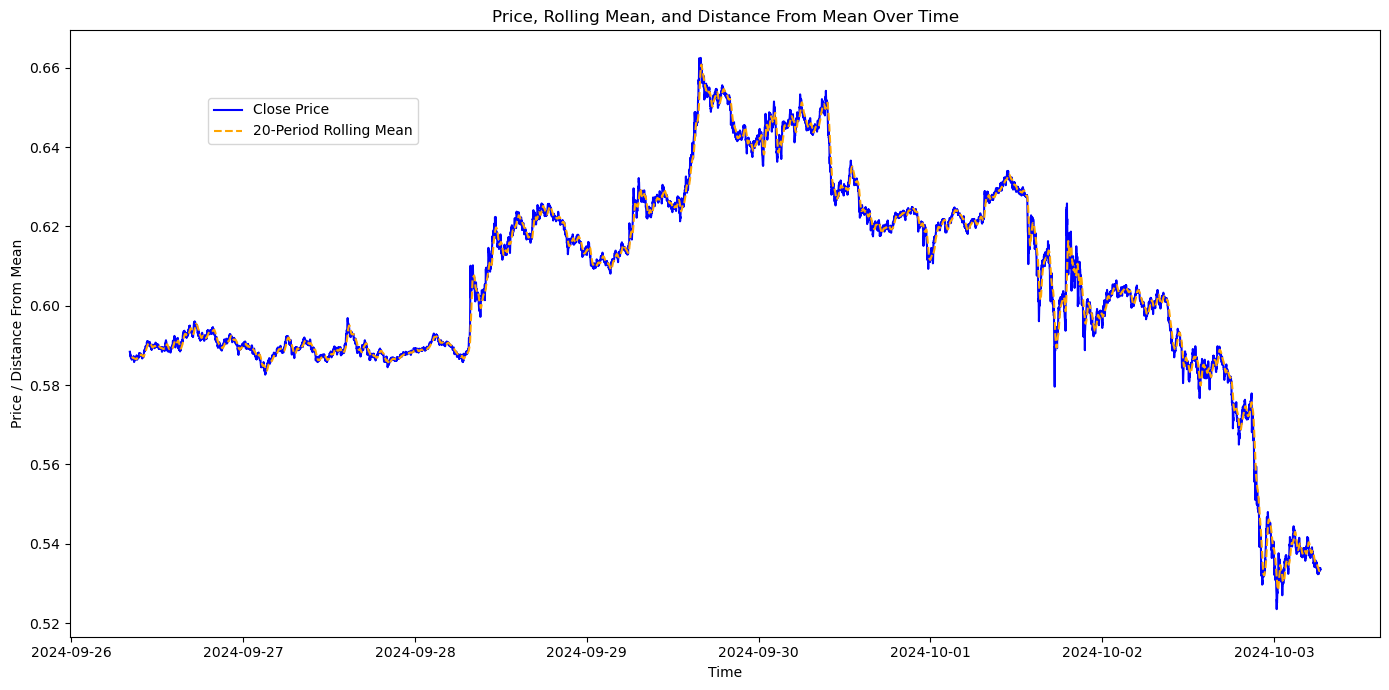

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'xrp_minute_data' is your DataFrame

# Convert 'Close' and 'Volume' columns to numeric, handling errors
xrp_minute_data['Close'] = pd.to_numeric(xrp_minute_data['Close'], errors='coerce')

# Drop any rows with NaN in 'Close' or 'Volume'
xrp_minute_data = xrp_minute_data.dropna(subset=['Close', 'Volume'])

# Create a rolling mean (e.g., 20-period moving average)
xrp_minute_data['Rolling Mean'] = xrp_minute_data['Close'].rolling(window=20).mean()


# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot price and rolling mean on the primary y-axis (ax1)
ax1.plot(xrp_minute_data['time'], xrp_minute_data['Close'], label='Close Price', color='blue')
ax1.plot(xrp_minute_data['time'], xrp_minute_data['Rolling Mean'], label='20-Period Rolling Mean', linestyle='--', color='orange')

# Set labels and title for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Price / Distance From Mean')
ax1.set_title('Price, Rolling Mean, and Distance From Mean Over Time')

# Add legends to both y-axes
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Show the plot
plt.tight_layout()
plt.show()

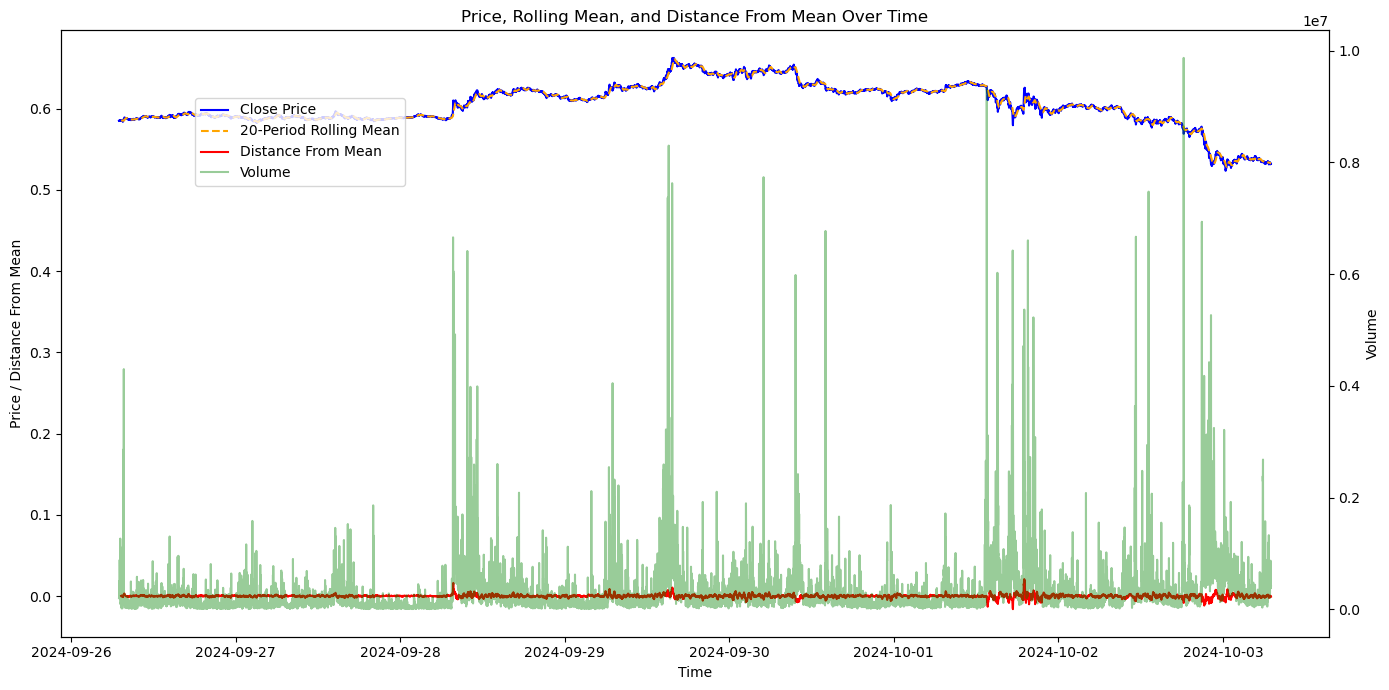

In [9]:
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Assuming 'xrp_minute_data' is your DataFrame

# Convert 'Close' and 'Volume' to numeric, handling errors
xrp_minute_data['Close'] = pd.to_numeric(xrp_minute_data['Close'], errors='coerce')
xrp_minute_data['Volume'] = pd.to_numeric(xrp_minute_data['Volume'], errors='coerce')

# Drop NaNs
xrp_minute_data = xrp_minute_data.dropna(subset=['Close', 'Volume'])

# Create a rolling mean (20-period moving average)
xrp_minute_data['Rolling Mean'] = xrp_minute_data['Close'].rolling(window=20).mean()

# Calculate distance from the mean
xrp_minute_data['Distance From Mean'] = xrp_minute_data['Close'] - xrp_minute_data['Rolling Mean']

# Create a subplot with two y-axes
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add Close Price and Rolling Mean (primary y-axis)
fig.add_trace(
    go.Scatter(x=xrp_minute_data['time'], y=xrp_minute_data['Close'],
               mode='lines', name='Close Price', line=dict(color='blue')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=xrp_minute_data['time'], y=xrp_minute_data['Rolling Mean'],
               mode='lines', name='20-Period Rolling Mean', line=dict(color='orange', dash='dash')),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=xrp_minute_data['time'], y=xrp_minute_data['Distance From Mean'],
               mode='lines', name='Distance From Mean', line=dict(color='red')),
    secondary_y=False,
)

# Add Volume (secondary y-axis)
fig.add_trace(
    go.Scatter(x=xrp_minute_data['time'], y=xrp_minute_data['Volume'],
               mode='lines', name='Volume', line=dict(color='green', opacity=0.4)),
    secondary_y=True,
)

# Set titles and labels
fig.update_layout(
    title='Interactive Price, Rolling Mean, and Volume Chart',
    xaxis_title='Time',
)

fig.update_yaxes(title_text='Price / Distance From Mean', secondary_y=False)
fig.update_yaxes(title_text='Volume', secondary_y=True)

# Show interactive plot
fig.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert 'Close' and 'Volume' columns to numeric, handling errors
xrp_minute_data['Close'] = pd.to_numeric(xrp_minute_data['Close'], errors='coerce')
xrp_minute_data['Volume'] = pd.to_numeric(xrp_minute_data['Volume'], errors='coerce')

# Drop any rows with NaN in 'Close' or 'Volume'
xrp_minute_data = xrp_minute_data.dropna(subset=['Close', 'Volume'])

# Create a rolling mean (e.g., 20-period moving average)
xrp_minute_data['Rolling Mean'] = xrp_minute_data['Close'].rolling(window=20).mean()

# Calculate the distance from the mean
xrp_minute_data['Distance From Mean'] = xrp_minute_data['Close'] - xrp_minute_data['Rolling Mean']

# Create the plot
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot distance from mean on the same y-axis
ax1.plot(xrp_minute_data['time'], xrp_minute_data['Distance From Mean'], label='Distance From Mean', color='red')

# Set labels and title for primary y-axis
ax1.set_xlabel('Time')
ax1.set_ylabel('Distance From Mean')
ax1.set_title('Distance From Mean Over Time')

# Create a second y-axis for the volume
ax2 = ax1.twinx()
ax2.plot(xrp_minute_data['time'], xrp_minute_data['Volume'], label='Volume', color='green', alpha=0.4)
ax2.set_ylabel('Volume')

# Add legends to both y-axes
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9), bbox_transform=ax1.transAxes)

# Show the plot
plt.tight_layout()
plt.show()

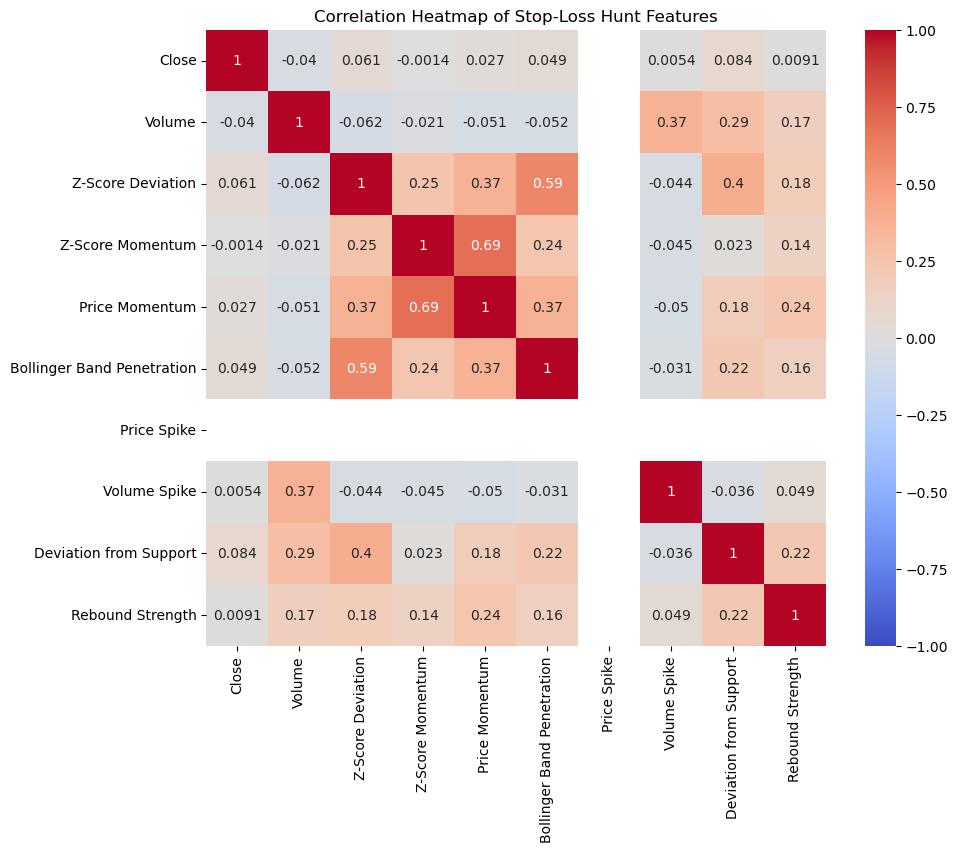

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate rolling mean and standard deviation for Bollinger Bands
xrp_minute_data['Rolling Mean'] = xrp_minute_data['Close'].rolling(window=20).mean()
xrp_minute_data['Rolling Std'] = xrp_minute_data['Close'].rolling(window=20).std()

# Bollinger Bands
xrp_minute_data['Upper Bollinger Band'] = xrp_minute_data['Rolling Mean'] + (2 * xrp_minute_data['Rolling Std'])
xrp_minute_data['Lower Bollinger Band'] = xrp_minute_data['Rolling Mean'] - (2 * xrp_minute_data['Rolling Std'])

# Z-Score Deviation from Mean
xrp_minute_data['Z-Score Deviation'] = (xrp_minute_data['Close'] - xrp_minute_data['Rolling Mean']) / xrp_minute_data['Rolling Std']

# Z-Score Momentum
xrp_minute_data['Z-Score Momentum'] = xrp_minute_data['Z-Score Deviation'].diff()

# Price Momentum
xrp_minute_data['Price Momentum'] = xrp_minute_data['Close'].diff()

# Bollinger Band Penetration
xrp_minute_data['Bollinger Band Penetration'] = np.where(xrp_minute_data['Close'] > xrp_minute_data['Upper Bollinger Band'], 1,
                                                         np.where(xrp_minute_data['Close'] < xrp_minute_data['Lower Bollinger Band'], -1, 0))

# Calculate Price Spike (e.g., 5% or more price drop within 5 periods)
xrp_minute_data['Price Spike'] = (xrp_minute_data['Close'].pct_change(periods=5) <= -0.05).astype(int)

# Calculate Volume Spike (e.g., 50% higher than average volume)
xrp_minute_data['Volume Spike'] = (xrp_minute_data['Volume'] > 1.5 * xrp_minute_data['Volume'].rolling(window=20).mean()).astype(int)

# Support Level (you could calculate this as a rolling minimum over a period)
xrp_minute_data['Support Level'] = xrp_minute_data['Close'].rolling(window=50).min()

# Deviation from Support Level
xrp_minute_data['Deviation from Support'] = xrp_minute_data['Close'] - xrp_minute_data['Support Level']

# Rebound Strength (recovery of price after price spike)
xrp_minute_data['Rebound Strength'] = (xrp_minute_data['Close'].shift(-10) - xrp_minute_data['Close']).rolling(window=5).max()

# Drop NaN values created by rolling calculations
xrp_minute_data.dropna(inplace=True)

# Select features for correlation analysis
features = ['Close', 'Volume', 'Z-Score Deviation', 'Z-Score Momentum', 'Price Momentum', 
            'Bollinger Band Penetration', 'Price Spike', 'Volume Spike', 
            'Deviation from Support', 'Rebound Strength']

# Compute correlation matrix
correlation_matrix = xrp_minute_data[features].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Stop-Loss Hunt Features')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Assuming both xrp_df and solo_df contain a 'Timestamp' column and 'Price' columns
plt.figure(figsize=(10, 6))

# Plot XRP price over time
plt.plot(xrp_df['Timestamp'], xrp_df['Price'], label='XRP Price', color='blue')

# Plot SOLO price over time
plt.plot(solo_df['Timestamp'], solo_df['Price'], label='SOLO Price', color='orange')

# Add titles and labels
plt.title('XRP and SOLO Prices Over Time')
plt.xlabel('Time')
plt.ylabel('Price')

# Add a legend
plt.legend()

# Display the plot
plt.show()

# Strategy Testing

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a 20-period rolling mean on the Close price
xrp_ohlcv_df['Rolling Mean'] = xrp_ohlcv_df['Close'].rolling(window=20).mean()

# Calculate the distance from the rolling mean
xrp_ohlcv_df['Distance From Mean'] = xrp_ohlcv_df['Close'] - xrp_ohlcv_df['Rolling Mean']

# Initialize variables to store trades and holding periods
profits = []
holding_periods = []

# Variables to track state
buy_price = None
buy_time = None

# Loop through the DataFrame to generate buy/sell signals
for i, row in xrp_ohlcv_df.iterrows():
    distance = row['Distance From Mean']
    close_price = row['Close']

    # Buy signal: distance drops below -0.004
    if distance < -0.004 and buy_price is None:
        buy_price = close_price
        buy_time = row['time']

    # Sell signal: price reaches the rolling mean again
    elif distance >= 0 and buy_price is not None:
        profit = close_price - buy_price
        profits.append(profit)  # Store the profit from the trade

        holding_period = (row['time'] - buy_time).total_seconds() / 60  # Holding period in minutes
        holding_periods.append(holding_period)  # Store the holding period

        # Reset buy state
        buy_price = None
        buy_time = None

# Calculate cumulative profit
cumulative_profit = sum(profits)

# Print results
print(f"Number of trades: {len(profits)}")
print(f"Cumulative Profit: {cumulative_profit}")
print(f"Average Holding Period: {sum(holding_periods) / len(holding_periods):.2f} minutes")

# Plot the distribution of holding periods
plt.figure(figsize=(10, 6))
plt.hist(holding_periods, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Holding Periods (Minutes)')
plt.xlabel('Holding Period (Minutes)')
plt.ylabel('Frequency')
plt.show()

# XGBoost

# XGBoost Strategy Simulation

# RNN

# LSTM

# Machine Learning for Feature Selection

Model Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1473
           1       0.69      0.67      0.68      1514

    accuracy                           0.68      2987
   macro avg       0.68      0.68      0.68      2987
weighted avg       0.68      0.68      0.68      2987

Feature Importances:
Z-Score Deviation             0.266691
Close                         0.205224
Price Momentum                0.198073
Volume                        0.159584
Volume Z-Score                0.158490
Bollinger Band Penetration    0.011938
Price Spike                   0.000000
dtype: float64


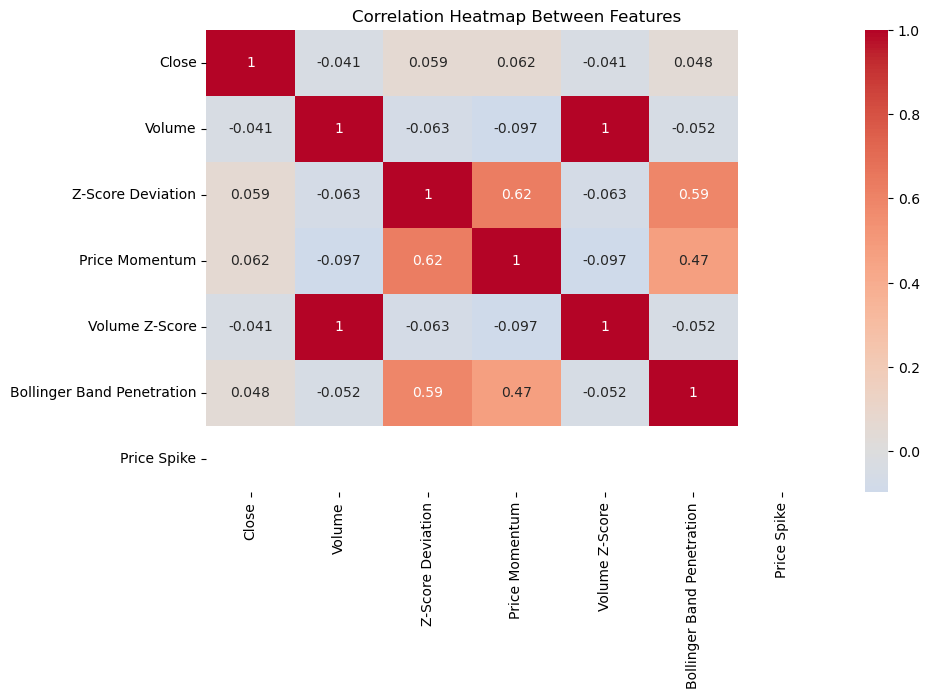

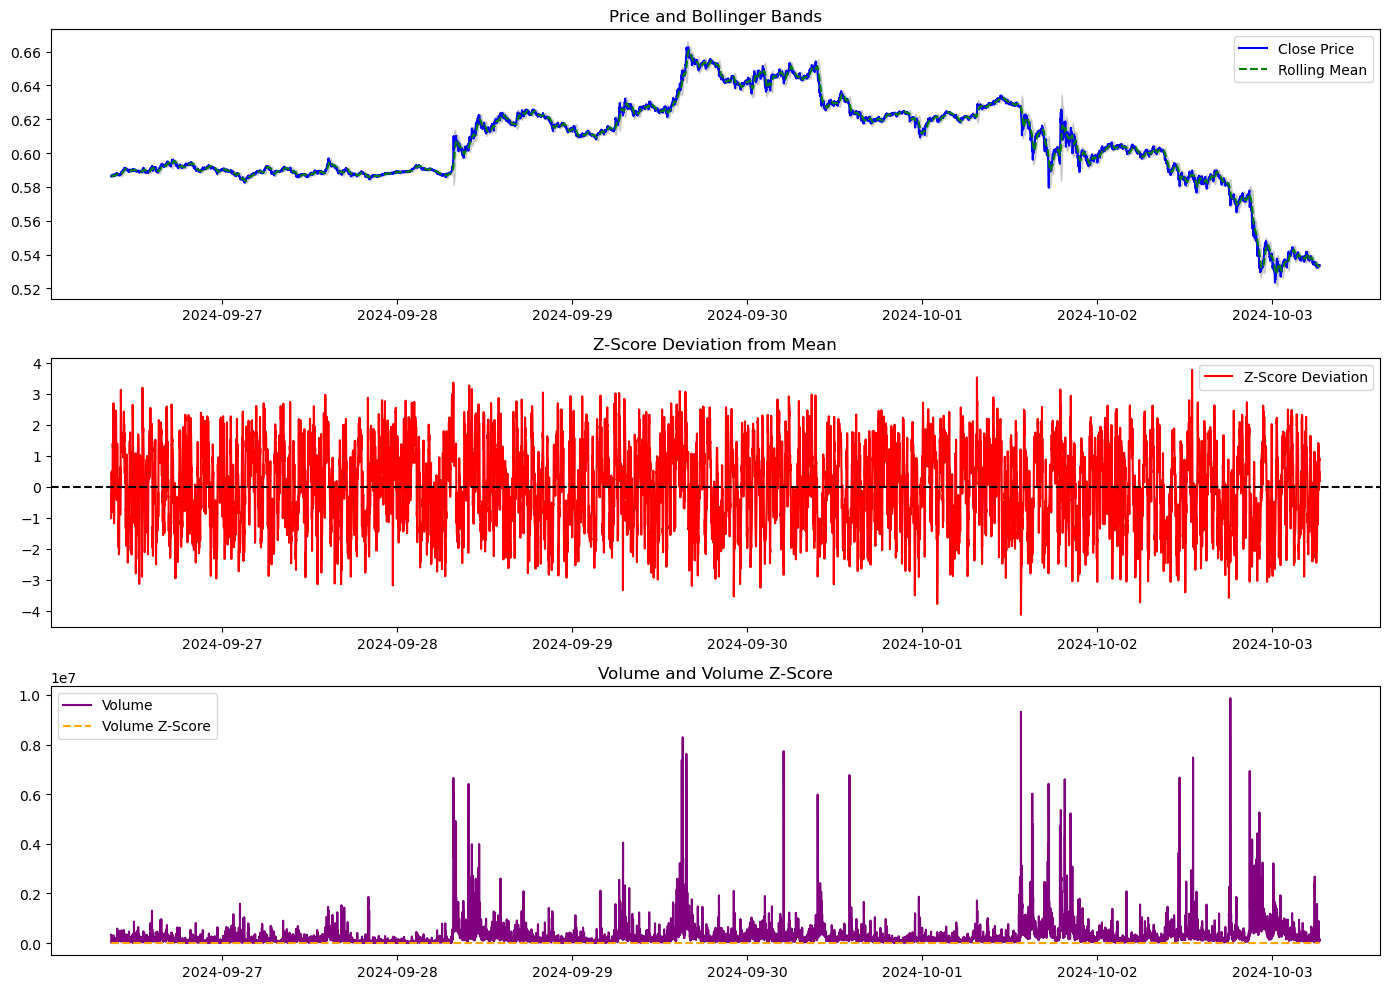

In [15]:
import pandas as pd
import numpy as np
import requests
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

# Feature Engineering

# 1. Rolling Mean (20-period) and Bollinger Bands
xrp_minute_data['Rolling Mean'] = xrp_minute_data['Close'].rolling(window=20).mean()
xrp_minute_data['Rolling Std'] = xrp_minute_data['Close'].rolling(window=20).std()
xrp_minute_data['Upper Bollinger Band'] = xrp_minute_data['Rolling Mean'] + (2 * xrp_minute_data['Rolling Std'])
xrp_minute_data['Lower Bollinger Band'] = xrp_minute_data['Rolling Mean'] - (2 * xrp_minute_data['Rolling Std'])

# 2. Z-Score Deviation from Mean
xrp_minute_data['Z-Score Deviation'] = (xrp_minute_data['Close'] - xrp_minute_data['Rolling Mean']) / xrp_minute_data['Rolling Std']

# 3. Price Momentum (percentage change over 5 periods)
xrp_minute_data['Price Momentum'] = xrp_minute_data['Close'].pct_change(periods=5)

# 4. Volume Spike (Z-score of volume)
xrp_minute_data['Volume Z-Score'] = StandardScaler().fit_transform(xrp_minute_data[['Volume']])

# 5. Bollinger Band Penetration (1 if price breaks upper, -1 if price breaks lower, 0 otherwise)
xrp_minute_data['Bollinger Band Penetration'] = np.where(xrp_minute_data['Close'] > xrp_minute_data['Upper Bollinger Band'], 1,
                                                         np.where(xrp_minute_data['Close'] < xrp_minute_data['Lower Bollinger Band'], -1, 0))

# 6. Price Spike Indicator (large downward movement)
xrp_minute_data['Price Spike'] = (xrp_minute_data['Close'].pct_change(periods=5) <= -0.05).astype(int)

# 7. Mean Reversion Target Variable (Price returning to Rolling Mean within 20 periods)
xrp_minute_data['Mean Reversion'] = (xrp_minute_data['Close'].shift(-20) > xrp_minute_data['Rolling Mean']).astype(int)

# Drop rows with NaN values caused by rolling calculations
xrp_minute_data.dropna(inplace=True)

# Machine Learning to Predict Mean Reversion
features = ['Close', 'Volume', 'Z-Score Deviation', 'Price Momentum', 'Volume Z-Score', 'Bollinger Band Penetration', 'Price Spike']
target = 'Mean Reversion'

# Split data into features (X) and target (y)
X = xrp_minute_data[features]
y = xrp_minute_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions and accuracy
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

# Feature Importance
feature_importances = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)
print("Feature Importances:")
print(feature_importances)

# Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(xrp_minute_data[features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap Between Features')
plt.show()

# Visualization

plt.figure(figsize=(14, 10))

# Plot 1: Price and Bollinger Bands
plt.subplot(3, 1, 1)
plt.plot(xrp_minute_data['time'], xrp_minute_data['Close'], label='Close Price', color='blue')
plt.plot(xrp_minute_data['time'], xrp_minute_data['Rolling Mean'], label='Rolling Mean', linestyle='--', color='green')
plt.fill_between(xrp_minute_data['time'], xrp_minute_data['Lower Bollinger Band'], xrp_minute_data['Upper Bollinger Band'], color='gray', alpha=0.3)
plt.title('Price and Bollinger Bands')
plt.legend()

# Plot 2: Distance from Mean (Z-Score Deviation)
plt.subplot(3, 1, 2)
plt.plot(xrp_minute_data['time'], xrp_minute_data['Z-Score Deviation'], label='Z-Score Deviation', color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title('Z-Score Deviation from Mean')
plt.legend()

# Plot 3: Volume and Volume Z-Score
plt.subplot(3, 1, 3)
plt.plot(xrp_minute_data['time'], xrp_minute_data['Volume'], label='Volume', color='purple')
plt.plot(xrp_minute_data['time'], xrp_minute_data['Volume Z-Score'], label='Volume Z-Score', color='orange', linestyle='--')
plt.title('Volume and Volume Z-Score')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Renaming columns to avoid conflicts during the merge
minute_xrp_sentiment_df = minute_xrp_sentiment_df.rename(columns={'weighted_sentiment_score': 'xrp_sentiment_score'})
xrp_price_df = xrp_price_df.rename(columns={'Price': 'xrp_price'})

# Exclude 'subreddit' and 'keyword' columns if they exist
xrp_columns_to_include = [col for col in minute_xrp_sentiment_df.columns if col not in ['subreddit', 'keyword']]

# Merging data frames based on the 'time' column
# First, merge the XRP sentiment and SOLO sentiment data frames
merged_df = pd.merge(minute_xrp_sentiment_df[xrp_columns_to_include],
                     minute_solo_sentiment_df[solo_columns_to_include],
                     on='time', how='outer')

# Merge the resulting data frame with the XRP price data
merged_df = pd.merge(merged_df,
                     xrp_price_df[['time', 'xrp_price']],
                     on='time', how='outer')

# Sort the final merged data frame by 'time' to ensure proper time-wise alignment
merged_df = merged_df.sort_values(by='time').reset_index(drop=True)

# Display the final merged DataFrame
print(merged_df.head())

# Optionally save the merged data to a CSV file
merged_df.to_csv('merged_sentiment_price_data.csv', index=False)

In [77]:
# Ensure 'time' column in reddit_df is localized to UTC and 'Datetime' column in xrp_df is converted to UTC if already aware
reddit_df['time'] = pd.to_datetime(reddit_df['time']).dt.tz_convert('UTC')
xrp_df['Datetime'] = pd.to_datetime(xrp_df['Datetime']).dt.tz_convert('UTC')  # Use tz_convert instead of tz_localize

# Now that both are in the same timezone, proceed with the merge
merged_df = pd.merge_asof(
    xrp_df.sort_values('Datetime'),
    reddit_df.sort_values('time'),
    left_on='Datetime',
    right_on='time',
    direction='backward'
)

# Forward fill missing sentiment data
merged_df['sentiment_score'] = merged_df['sentiment_score'].fillna(method='ffill')

# Remove rows where 'sentiment_score' is NaN
merged_df = merged_df.dropna(subset=['sentiment_score'])

# Print out the merged data to see how it aligns
print("Merged Data Preview:")
print(merged_df.head())

Merged Data Preview:
                     Datetime      Open      High       Low     Close  \
558 2024-09-20 09:32:00+00:00  0.589876  0.589876  0.589876  0.589876   
559 2024-09-20 09:33:00+00:00  0.589867  0.589867  0.589867  0.589867   
560 2024-09-20 09:34:00+00:00  0.589480  0.589480  0.589480  0.589480   
561 2024-09-20 09:35:00+00:00  0.589424  0.589424  0.589424  0.589424   
562 2024-09-20 09:36:00+00:00  0.589322  0.589322  0.589322  0.589322   

     Adj Close  Volume       subreddit                      time  \
558   0.589876  447744  cryptocurrency 2024-09-20 09:31:00+00:00   
559   0.589867  153600  cryptocurrency 2024-09-20 09:31:00+00:00   
560   0.589480   22784  cryptocurrency 2024-09-20 09:31:00+00:00   
561   0.589424  221824  cryptocurrency 2024-09-20 09:31:00+00:00   
562   0.589322   91904  cryptocurrency 2024-09-20 09:31:00+00:00   

     sentiment_score  type                                               text  
558        -2.613107  post  Supreme Court of India 

In [78]:
# Feature Engineering on Price Data
xrp_df['price_change_pct'] = xrp_df['Close'].pct_change()
xrp_df['volume_change_pct'] = xrp_df['Volume'].pct_change()

# Sentiment Momentum and Volatility
merged_df['sentiment_roc'] = merged_df['sentiment_score'].diff()
merged_df['sentiment_volatility'] = merged_df['sentiment_score'].rolling(window=30).std()

print("After sentiment momentum and volatility:")
print(merged_df.isna().sum())

# Z-Score of Price relative to MA_50
merged_df['MA_50'] = merged_df['Close'].rolling(window=50).mean()
merged_df['price_volatility_50'] = merged_df['Close'].rolling(window=50).std()
merged_df['z_score'] = (merged_df['Close'] - merged_df['MA_50']) / merged_df['price_volatility_50']

print("After Z-Score and MA_50:")
print(merged_df.isna().sum())

# Bollinger Bands
bollinger = ta.volatility.BollingerBands(close=merged_df['Close'], window=20, window_dev=2)
merged_df['upper_band'] = bollinger.bollinger_hband()
merged_df['middle_band'] = bollinger.bollinger_mavg()
merged_df['lower_band'] = bollinger.bollinger_lband()

print("After Bollinger Bands:")
print(merged_df.isna().sum())

# Relative Strength Index (RSI)
merged_df['RSI_14'] = ta.momentum.RSIIndicator(merged_df['Close'], window=14).rsi()

print("After RSI:")
print(merged_df.isna().sum())

# On-Balance Volume (OBV)
merged_df['OBV'] = ta.volume.OnBalanceVolumeIndicator(merged_df['Close'], merged_df['Volume']).on_balance_volume()

print("After OBV:")
print(merged_df.isna().sum())

# Additional Technical Indicators
# Rate of Change (ROC)
merged_df['ROC_5'] = ta.momentum.ROCIndicator(merged_df['Close'], window=5).roc()
merged_df['ROC_10'] = ta.momentum.ROCIndicator(merged_df['Close'], window=10).roc()
merged_df['ROC_30'] = ta.momentum.ROCIndicator(merged_df['Close'], window=30).roc()

print("After ROC:")
print(merged_df.isna().sum())

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(merged_df['Close'])
merged_df['MACD'] = macd.macd()
merged_df['MACD_signal'] = macd.macd_signal()
merged_df['MACD_diff'] = macd.macd_diff()

print("After MACD:")
print(merged_df.isna().sum())

# Percentage Price Oscillator (PPO)
merged_df['PPO'] = ta.momentum.PercentagePriceOscillator(merged_df['Close']).ppo()

print("After PPO:")
print(merged_df.isna().sum())

After sentiment momentum and volatility:
Datetime                 0
Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
subreddit                0
time                     0
sentiment_score          0
type                     0
text                     0
sentiment_roc            1
sentiment_volatility    29
dtype: int64
After Z-Score and MA_50:
Datetime                 0
Open                     0
High                     0
Low                      0
Close                    0
Adj Close                0
Volume                   0
subreddit                0
time                     0
sentiment_score          0
type                     0
text                     0
sentiment_roc            1
sentiment_volatility    29
MA_50                   49
price_volatility_50     49
z_score                 49
dtype: int64
After Bollinger Bands:
Datetime                 0
Open                 

In [79]:
# Define the relevant variables/columns for correlation analysis
relevant_columns = [
    'Datetime',               # Time column (keep this for timestamping, might not be used in correlation)
    'Close',                  # Closing price
    'Volume',                 # Volume of trades
    'sentiment_score',        # Sentiment score
    'sentiment_roc',          # Rate of change in sentiment
    'sentiment_volatility',   # Volatility of sentiment
    'MA_50',                  # 50-period moving average
    'price_volatility_50',    # Price volatility over a 50-period window
    'z_score',                # Z-score of price relative to MA_50
    'upper_band',             # Upper Bollinger Band
    'middle_band',            # Middle Bollinger Band (20-period SMA)
    'lower_band',             # Lower Bollinger Band
    'RSI_14',                 # 14-period RSI (Relative Strength Index)
    'OBV',                    # On-Balance Volume
    'ROC_5',                  # Rate of Change over 5 periods
    'ROC_10',                 # Rate of Change over 10 periods
    'ROC_30',                 # Rate of Change over 30 periods
    'MACD',                   # Moving Average Convergence Divergence
    'MACD_signal',            # MACD signal line
    'MACD_diff',              # MACD histogram (MACD - MACD signal)
    'PPO'                     # Percentage Price Oscillator
]

# Create a new DataFrame with the selected relevant columns
relevant_df = merged_df[relevant_columns]

# Remove any rows with missing values (optional, depending on your analysis approach)
relevant_df = relevant_df.dropna()

# Display the first few rows of the new DataFrame with relevant variables
print(relevant_df.head())

                     Datetime     Close  Volume  sentiment_score  \
607 2024-09-20 10:23:00+00:00  0.587822  518784        -2.613107   
608 2024-09-20 10:24:00+00:00  0.587966  375168        -2.613107   
609 2024-09-20 10:25:00+00:00  0.588248  173184        -2.613107   
610 2024-09-20 10:26:00+00:00  0.588214  113408        -2.613107   
611 2024-09-20 10:27:00+00:00  0.588187       0        -2.613107   

     sentiment_roc  sentiment_volatility     MA_50  price_volatility_50  \
607            0.0                   0.0  0.588179             0.000603   
608            0.0                   0.0  0.588140             0.000552   
609            0.0                   0.0  0.588108             0.000493   
610            0.0                   0.0  0.588083             0.000452   
611            0.0                   0.0  0.588058             0.000409   

      z_score  upper_band  ...  lower_band     RSI_14     OBV     ROC_5  \
607 -0.590185    0.588157  ...    0.587350  48.702353  -36096  0.

In [80]:
print(relevant_df.isna().sum())

Datetime                0
Close                   0
Volume                  0
sentiment_score         0
sentiment_roc           0
sentiment_volatility    0
MA_50                   0
price_volatility_50     0
z_score                 0
upper_band              0
middle_band             0
lower_band              0
RSI_14                  0
OBV                     0
ROC_5                   0
ROC_10                  0
ROC_30                  0
MACD                    0
MACD_signal             0
MACD_diff               0
PPO                     0
dtype: int64


Filtered Correlation Matrix (only highly correlated variables):
                Close     MA_50   z_score  upper_band  middle_band  \
Close        1.000000  0.963230  0.092144    0.979536     0.986655   
MA_50        0.963230  1.000000 -0.114104    0.972504     0.985418   
z_score      0.092144 -0.114104  1.000000   -0.025849    -0.023013   
upper_band   0.979536  0.972504 -0.025849    1.000000     0.988826   
middle_band  0.986655  0.985418 -0.023013    0.988826     1.000000   
lower_band   0.970299  0.975197 -0.019469    0.953148     0.987593   
RSI_14       0.071894 -0.135825  0.936683   -0.053323    -0.053581   
ROC_5        0.066024 -0.075831  0.525904   -0.046492    -0.063778   
ROC_10       0.101191 -0.088484  0.641185   -0.032274    -0.053184   
ROC_30       0.188125 -0.069970  0.701787    0.094844     0.073656   
MACD         0.208114 -0.055723  0.718923    0.106340     0.085264   
MACD_signal  0.222181 -0.026020  0.630468    0.150906     0.134605   
MACD_diff   -0.005962 -0.1

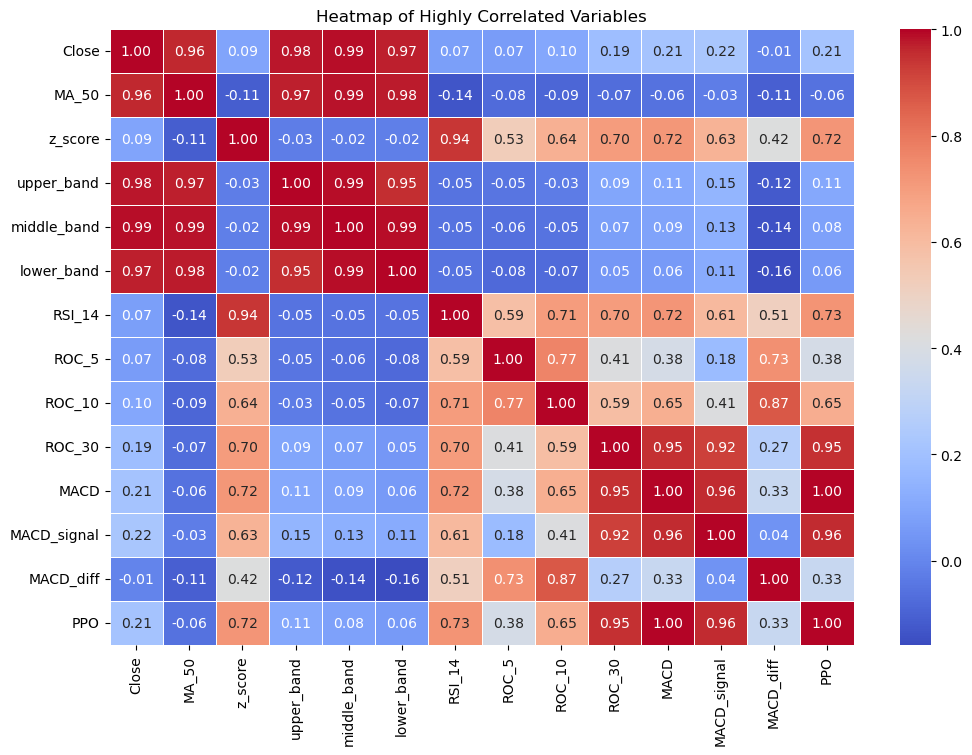

In [81]:
import numpy as np

# Define a threshold for strong correlations (absolute value > 0.5)
threshold = 0.5

# Get the full correlation matrix
correlation_matrix = relevant_df.corr()

# Create a boolean mask to filter variables where the absolute correlation is above the threshold, excluding self-correlations
mask = (correlation_matrix.abs() >= threshold) & (correlation_matrix != 1.0)

# Find columns (variables) that have any correlation above the threshold
high_corr_vars = mask.any(axis=0)

# Filter the correlation matrix to include only those variables
filtered_correlation_matrix = correlation_matrix.loc[high_corr_vars, high_corr_vars]

# Print the filtered correlation matrix for highly correlated variables
print("Filtered Correlation Matrix (only highly correlated variables):")
print(filtered_correlation_matrix)

# Plot the heatmap for the actual correlation matrix of filtered variables
plt.figure(figsize=(12, 8))
sns.heatmap(filtered_correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Highly Correlated Variables")
plt.show()

Correlation Matrix:
                         Close    Volume  sentiment_score  sentiment_roc  \
Close                 1.000000  0.174394         0.108561      -0.001713   
Volume                0.174394  1.000000        -0.031524       0.021226   
sentiment_score       0.108561 -0.031524         1.000000       0.202391   
sentiment_roc        -0.001713  0.021226         0.202391       1.000000   
sentiment_volatility  0.282507  0.075257        -0.021317       0.004815   
MA_50                 0.963230  0.118840         0.101661      -0.001356   
price_volatility_50   0.239626  0.346217        -0.102530       0.004799   
z_score               0.092144  0.051738         0.063727      -0.004826   
upper_band            0.979536  0.208392         0.088674       0.000035   
middle_band           0.986655  0.138575         0.110756      -0.000300   
lower_band            0.970299  0.061681         0.131338      -0.000647   
RSI_14                0.071894  0.056426         0.045649      -0.00

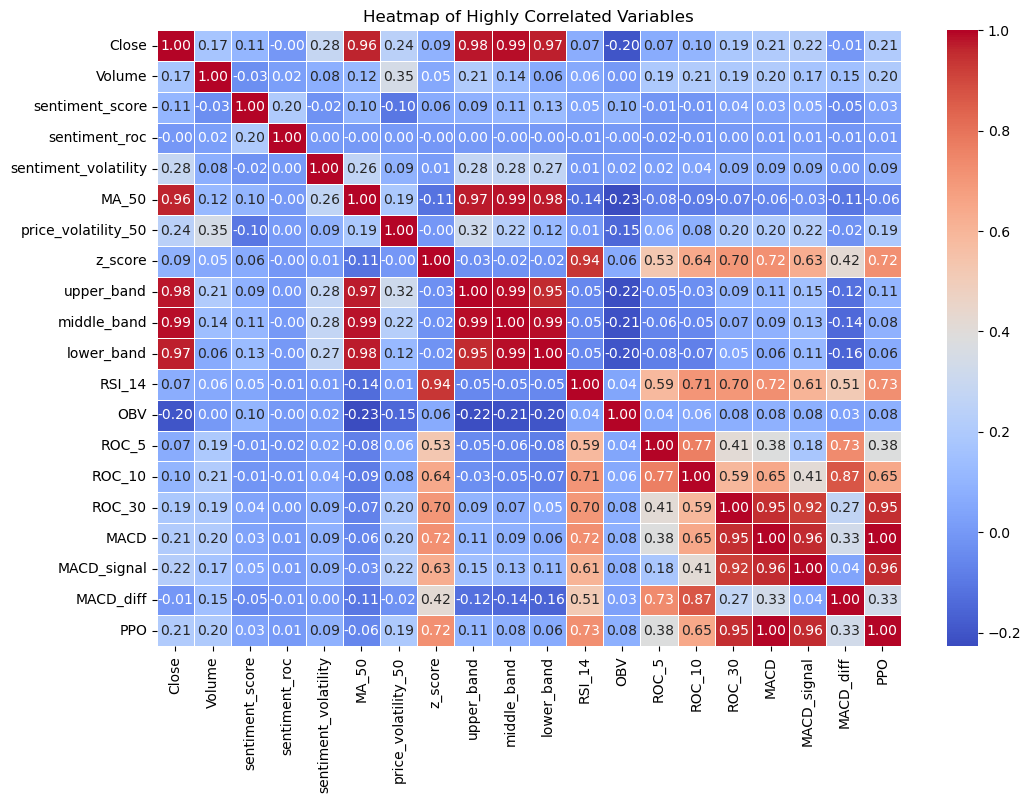

In [82]:
import numpy as np

# Get the full correlation matrix
correlation_matrix = relevant_df.corr()

# Print the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the heatmap for the actual correlation matrix of filtered variables
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Highly Correlated Variables")
plt.show()

In [84]:
relevant_df.columns

Index(['Datetime', 'Close', 'Volume', 'sentiment_score', 'sentiment_roc',
       'sentiment_volatility', 'MA_50', 'price_volatility_50', 'z_score',
       'upper_band', 'middle_band', 'lower_band', 'RSI_14', 'OBV', 'ROC_5',
       'ROC_10', 'ROC_30', 'MACD', 'MACD_signal', 'MACD_diff', 'PPO'],
      dtype='object')

In [86]:
# Drop the 'Datetime' column from the DataFrame
relevant_df_nodate = relevant_df.drop('Datetime', axis=1)

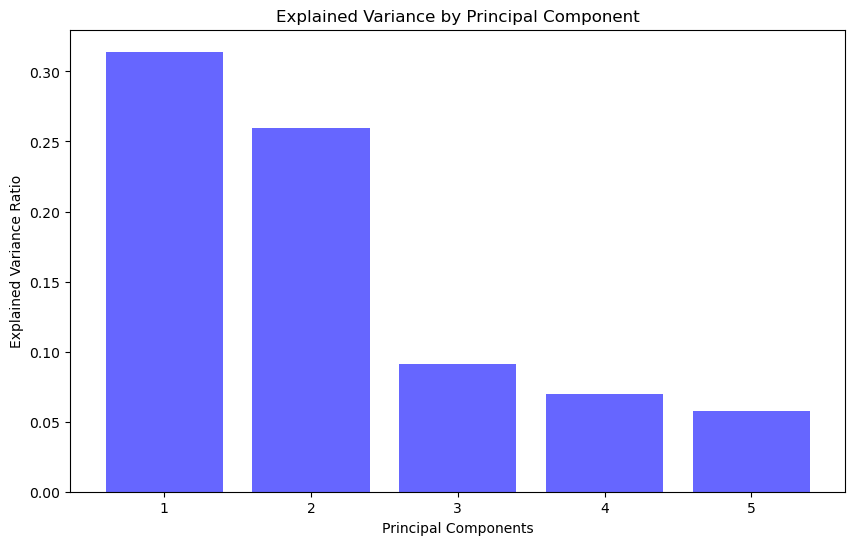

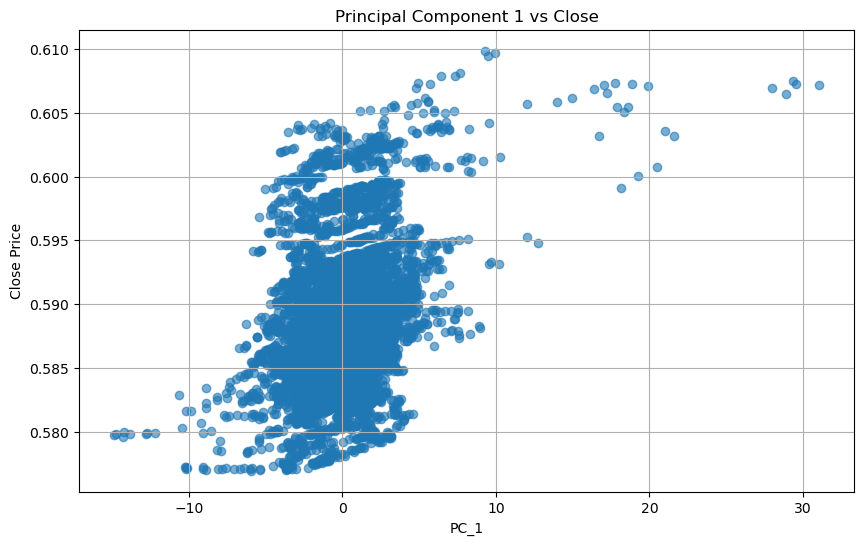

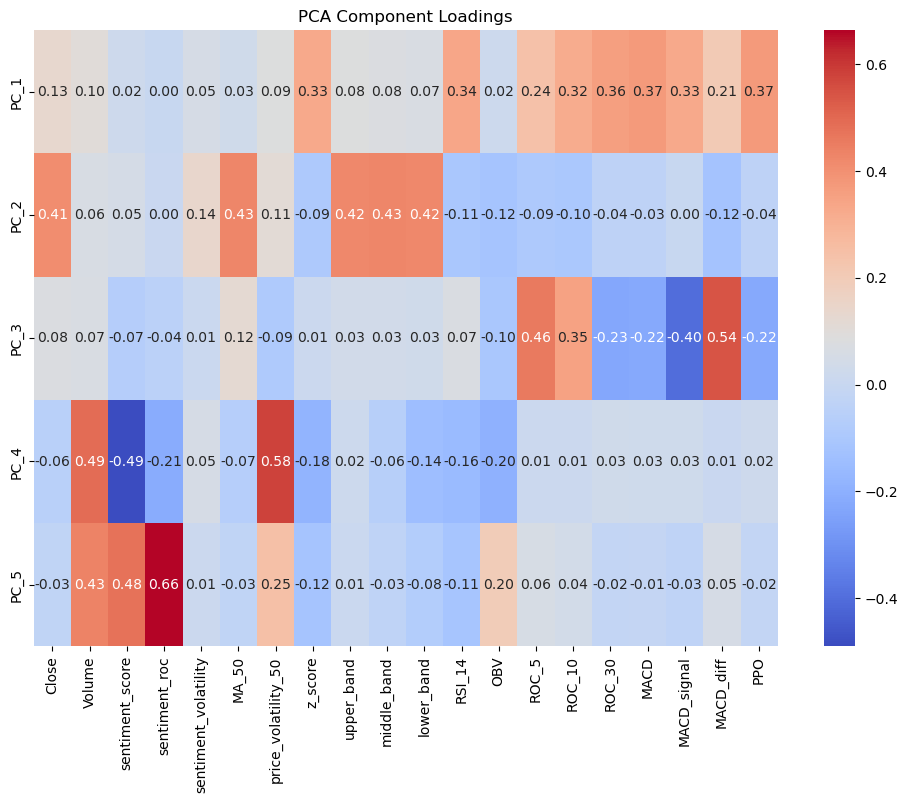

Most Correlated Variables with PC1:
PC_1                    1.000000e+00
PPO                     9.350392e-01
MACD                    9.345395e-01
ROC_30                  9.051558e-01
RSI_14                  8.433242e-01
z_score                 8.275750e-01
MACD_signal             8.272569e-01
ROC_10                  7.962409e-01
ROC_5                   6.067440e-01
MACD_diff               5.212949e-01
Close                   3.325911e-01
Close                   3.325911e-01
Volume                  2.601967e-01
price_volatility_50     2.141185e-01
upper_band              2.123943e-01
middle_band             1.910375e-01
lower_band              1.639222e-01
sentiment_volatility    1.309020e-01
MA_50                   7.672116e-02
sentiment_score         4.980154e-02
OBV                     4.682346e-02
sentiment_roc           6.269098e-04
PC_5                    9.455469e-16
PC_2                    2.357162e-16
PC_4                    2.143047e-16
PC_3                    6.677174e-17
Na

In [88]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Standardize the data before applying PCA (mean=0, variance=1)
scaler = StandardScaler()
standardized_data = scaler.fit_transform(relevant_df_nodate)

# Perform PCA
pca = PCA(n_components=5)  # Choose 5 components for now; you can experiment with different numbers
pca_result = pca.fit_transform(standardized_data)

# Create a DataFrame for the PCA results
pca_columns = [f'PC_{i+1}' for i in range(pca.n_components_)]
pca_df = pd.DataFrame(data=pca_result, columns=pca_columns)

# Add the first principal component to relevant_df
relevant_df_pca = relevant_df.reset_index(drop=True)  # Reset index for merging
pca_df = pd.concat([pca_df, relevant_df_pca[['Close']]], axis=1)  # Add the Close column back for reference

# Visualize the explained variance ratio of each principal component
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_, alpha=0.6, color='b', align='center')
plt.title('Explained Variance by Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Plot correlation between first principal component and 'Close'
plt.figure(figsize=(10, 6))
plt.scatter(pca_df['PC_1'], pca_df['Close'], alpha=0.6)
plt.title('Principal Component 1 vs Close')
plt.xlabel('PC_1')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

# Heatmap of correlations between the principal components and the original variables
relevant_columns_pca = relevant_df_nodate.columns  # Use original columns without 'Datetime'
pca_loading_matrix = pd.DataFrame(pca.components_, columns=relevant_columns_pca, index=pca_columns)

plt.figure(figsize=(12, 8))
sns.heatmap(pca_loading_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('PCA Component Loadings')
plt.show()

# Check the correlation matrix of the PCA components with other relevant variables
pca_correlation_matrix = pd.concat([pca_df, relevant_df_pca], axis=1).corr()

# Filter to get the most correlated variables with PC1
filtered_correlation_matrix = pca_correlation_matrix.loc['PC_1'].abs().sort_values(ascending=False)

# Display the most correlated variables with PC1
print("Most Correlated Variables with PC1:")
print(filtered_correlation_matrix)

In [89]:
# Create a DataFrame to hold the loadings (weights of each variable for each component)
pca_loading_matrix = pd.DataFrame(pca.components_, columns=relevant_columns_pca, index=pca_columns)

# Display the PCA loading matrix
print(pca_loading_matrix)

         Close    Volume  sentiment_score  sentiment_roc  \
PC_1  0.132701  0.103816         0.019870       0.000250   
PC_2  0.408815  0.060922         0.046593       0.003495   
PC_3  0.076928  0.067264        -0.070453      -0.044540   
PC_4 -0.057372  0.492146        -0.490132      -0.213396   
PC_5 -0.028499  0.434400         0.475271       0.663800   

      sentiment_volatility     MA_50  price_volatility_50   z_score  \
PC_1              0.052229  0.030611             0.085432  0.330196   
PC_2              0.136807  0.428842             0.113267 -0.091123   
PC_3              0.007117  0.120067            -0.085649  0.012232   
PC_4              0.052525 -0.066217             0.579176 -0.183869   
PC_5              0.013743 -0.026761             0.246359 -0.120189   

      upper_band  middle_band  lower_band    RSI_14       OBV     ROC_5  \
PC_1    0.084744     0.076222    0.065404  0.336479  0.018682  0.242086   
PC_2    0.424710     0.427871    0.420856 -0.106284 -0.117065 